In [62]:
################################
# Scientific imports
###
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

###
# General imports
###
import csv, math, io, os, os.path, sys, random, time
import pandas as pd
import seaborn as sb
from tqdm.notebook import tqdm, trange

###
# SciKitLearn Imports
###
import sklearn
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from IPython.display import display

###
# MatPlotLib Settings
###

plt.rcParams["figure.figsize"] = (20,9)
sb.set()

In [33]:
# Load the Data files
#fitsarr = np.load("fitslist.npy")
fluxarr = np.load("fluxlist.npy")
#planetarr = np.load("planetlist.npy")
isplanetarr = np.load("isplanetlist.npy")

In [3]:
# 6 sets of SVC parameters to plot a basic ROC/AUC with -- used for later on! Since params are defined outside the grid, can always modify for future expansion

svcC = [1, 5, 10, 25, 50, 75]
svcG = [0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.0075]

param_grid = {'svc__C': svcC,
              'svc__gamma': svcG}

#param_grid = np.vstack((svcC, svcG)).T

for key, pairs in param_grid.items():
    for pair in pairs:
        print (key,"::",pair)

svc__C :: 1
svc__C :: 5
svc__C :: 10
svc__C :: 25
svc__C :: 50
svc__C :: 75
svc__gamma :: 0.0001
svc__gamma :: 0.0005
svc__gamma :: 0.001
svc__gamma :: 0.0025
svc__gamma :: 0.005
svc__gamma :: 0.0075


In [4]:
param_grid.items()

dict_items([('svc__C', [1, 5, 10, 25, 50, 75]), ('svc__gamma', [0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.0075])])

In [5]:
# Make a PCA Pipeline
pca = PCA(svd_solver='randomized', n_components=2, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

# Sort data into Test and Train
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(fluxarr, isplanetarr, random_state=42)

# IsPlanetArr is an array of TRUEs and FALSEs -- need it to be 0s and 1s
isplanetarrbin = [1 if x==True else 0 for x in isplanetarr]
#plt.hist(isplanetarrbin)

# Fit model
pca.fit(Xtrain,ytrain)

# Use PCA transform on Xtrain --- I don't quite know what this does but it seems to make things work so wahey!
pca.transform(Xtrain)

array([[ 0.74475579, -0.1849862 ],
       [-0.13956263,  0.03318039],
       [-0.16695046,  0.03208855],
       ...,
       [-0.16671307,  0.03203889],
       [-0.07404131,  0.12968034],
       [-0.09193118,  0.01484429]])

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [6]:
# So svc__C = 50, svc__gamma = 0.005 is best, which is the highest of each grid. Let's try more to see
from sklearn.model_selection import GridSearchCV
#param_grid = {'svc__C': [50],
#              'svc__gamma': [0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 2h 40min 5s, sys: 1h 1min 6s, total: 3h 41min 11s
Wall time: 35min 9s
{'svc__C': 50, 'svc__gamma': 0.005}


Need to find a way to output the True Positive Rate (TPR, aks Recall) and False Positive Rate (FPR) from my models, based on different svc__ parameters.  
Therefore, need to run my model at each set of params, and then record the TPR and FPR at each interval.  
This can be done by making a confusion matrix:  
``from sklearn.metrics import confusion_matrix``  
``mat = confusion_matrix(ytest, yfitnew)``  

And using the following:  
True Positive (TP)  = mat[0][0]  
False Positive (FP) = mat[1][0]  
True Negative (TN)  = mat[1][1]  
False Negative (FN) = mat[0][1]

We can work out the TPR and FPR values, and record them somewhere.  
It's a tad convoluted, but it will work. I just need to work out how to loop thru values of my grid_params

STEPS:  
1) Get a list of svc__* parameters (henceforth svc)
2) Write the function to make a model using data from test-train-split
3) Once run, get confusion matrix, and calculate TRP and FPR from it
4) Store these variables, along with the svc params, somewhere
5) Repeat this for many many many svc params, yielding a set of svcs, TPRs and FPRs
6) Plot this to make an ROC, and calculate the AUC

Essentially this is a Fn that wraps the actual ML algorithm within a for loop, passing in new svc's each loop  
Interestingly, svc__gamma always seems to be 1/10000 of svc__C, so I can use this to my advantage -- Loop one number, eg 0, 5, 10, 15, 20, 25... for svcC and then just
divide by 10000 to get svcGamma.

In [64]:
def GetROC(dataArr, checkArr):
    
    # Output list
    rocpts = []
    
    # Make list of numbers we can use for svc__C and svc__gamma
    svcList = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
    
    # Reformat checkArr to use 0/1 instead of True/False
    isplanetarrbin = [1 if x==True else 0 for x in isplanetarr]
    
    # Make the loop, with svc__C and svc__gamma (henceforth svcC and svcG) values calculated
    for svcC in svcList:
        svcG = svcC / 10000
        #print("svc__C = {}\nsvc__gamma = {}".format(svcC, svcG))
        
        # Call the main ML algo, passing in relevant params
        TPR, FPR = GetPositiveRates(dataArr, isplanetarrbin, {'svc__C': [svcC], 'svc__gamma': [svcG]})
        
        print("svc__C = {}\nsvc__gamma = {}\nTPR = {}\nFPR = {}".format(svcC, svcG, TPR, FPR))
        
        rocpts.append([svcC, svcG, TPR, FPR])
    return rocpts

################################################################################################################33

def GetPositiveRates(dataArr, checkArr, param_grid):

    # Make a PCA Pipeline
    pca = PCA(svd_solver='randomized', n_components=2, whiten=True, random_state=42) # using 2 components as a timeseries is essentially a 2D graph
    svc = SVC(kernel='rbf', class_weight='balanced')
    model = make_pipeline(pca, svc)
    
    # Reformat isplanetarr to use 0/1 instead of T/F
    #checkArr = [1 if x==True else 0 for x in checkArr]

    # Sort data into Test and Train
    Xtrain, Xtest, ytrain, ytest = train_test_split(dataArr, checkArr, random_state=42)
    
    # Do gridsearch for svc params
    grid = GridSearchCV(model, param_grid)
    
    # Fit model
    grid.fit(Xtrain, ytrain)
    
    # Use svc params and predict    
    model = grid.best_estimator_
    yfit = model.predict(Xtest)

    # Use PCA transform on Xtrain --- I don't quite know what this does but it seems to make things work so wahey!
    #pca.transform(Xtrain)
    
    #
    #
    # Now that model has done, time for confusion matrix shenanigans
    mat = confusion_matrix(ytest, yfit)
    TP = mat[0][0]  
    FP = mat[1][0]  
    TN = mat[1][1]  
    FN = mat[0][1]
    #TOT= sum(list(map(sum, mat)))

    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    
    return (TPR, FPR)

In [65]:
rocpoints = np.array(GetROC(fluxarr, isplanetarr))

svc__C = 1
svc__gamma = 0.0001
TPR = 1.0
FPR = 1.0
svc__C = 5
svc__gamma = 0.0005
TPR = 0.9972367209088118
FPR = 0.9986541049798116
svc__C = 10
svc__gamma = 0.001
TPR = 0.9966226588885477
FPR = 0.9986541049798116
svc__C = 15
svc__gamma = 0.0015
TPR = 0.9947804728277556
FPR = 0.9986541049798116
svc__C = 20
svc__gamma = 0.002
TPR = 0.9877187595947191
FPR = 0.9946164199192463
svc__C = 25
svc__gamma = 0.0025
TPR = 0.9806570463616825
FPR = 0.9865410497981157
svc__C = 30
svc__gamma = 0.003
TPR = 0.9800429843414185
FPR = 0.9771197846567967
svc__C = 35
svc__gamma = 0.0035
TPR = 0.9751304881793061
FPR = 0.9771197846567967
svc__C = 40
svc__gamma = 0.004
TPR = 0.9702179920171937
FPR = 0.971736204576043
svc__C = 45
svc__gamma = 0.0045
TPR = 0.9686828369665336
FPR = 0.9703903095558546
svc__C = 50
svc__gamma = 0.005
TPR = 0.9674547129260055
FPR = 0.9690444145356663
svc__C = 55
svc__gamma = 0.0055
TPR = 0.9671476819158735
FPR = 0.9690444145356663
svc__C = 60
svc__gamma = 0.006
TPR = 0.967147681915873

In [39]:
rocpoints

array([[1.00000000e+00, 1.00000000e-04, 1.00000000e+00, 1.00000000e+00],
       [5.00000000e+00, 5.00000000e-04, 9.97236721e-01, 9.98654105e-01],
       [1.00000000e+01, 1.00000000e-03, 9.96622659e-01, 9.98654105e-01],
       [2.50000000e+01, 2.50000000e-03, 9.80657046e-01, 9.86541050e-01],
       [5.00000000e+01, 5.00000000e-03, 9.67454713e-01, 9.69044415e-01],
       [7.50000000e+01, 7.50000000e-03, 9.67147682e-01, 9.65006729e-01]])

In [66]:
Y = rocpoints[:, 2]
X = rocpoints[:, 3]

(0.9, 1.0)

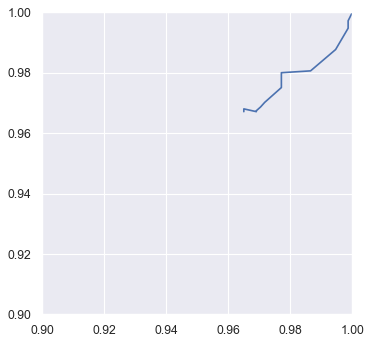

In [71]:
figure(figsize=(5,5), dpi=80)
plt.plot(X,Y)
scale=[0.9,1]
plt.xlim(scale)
plt.ylim(scale)

In [74]:
isplanetarrbin = [1 if x==True else 0 for x in isplanetarr]
Xtrain, Xtest, ytrain, ytest = train_test_split(fluxarr, isplanetarrbin, random_state=42)

In [76]:
pca = PCA(svd_solver='randomized', n_components=2, whiten=True, random_state=42)

In [84]:
pca.fit(Xtrain.T)

PCA(n_components=2, random_state=42, svd_solver='randomized', whiten=True)

In [85]:
pca.components_

array([[-8.21381032e-03, -2.58834927e-04, -1.23896050e-05, ...,
        -1.45277026e-05, -8.49562105e-04, -6.87209826e-04],
       [ 1.95587391e-03, -7.86971882e-06,  3.07314149e-06, ...,
         3.51230653e-06, -8.95882257e-04,  1.58094848e-04]])

In [86]:
len(pca.components_[0])

12000

In [87]:
len(pca.components_[1])

12000

In [89]:
len(ytrain)

12000

(-0.05, 0.05)

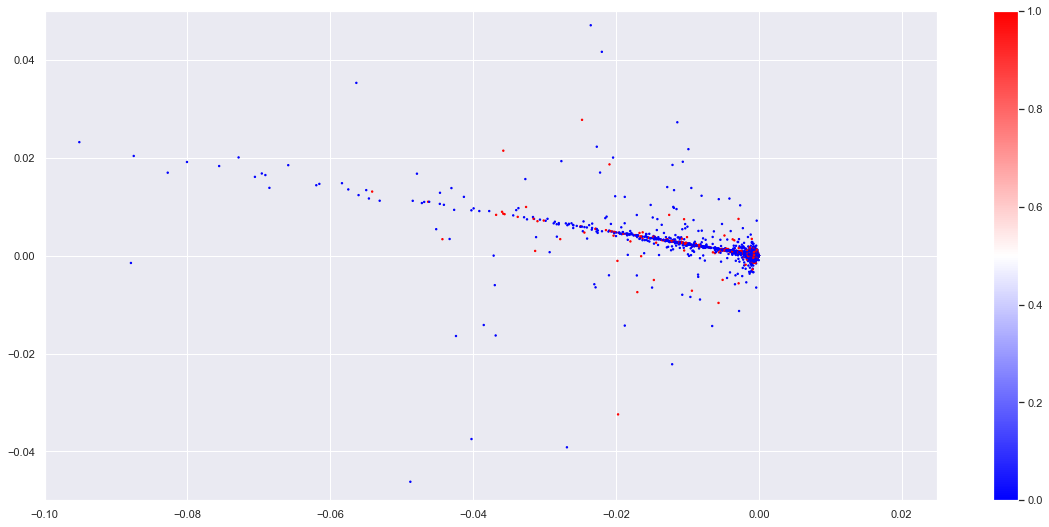

In [100]:
plt.scatter(pca.components_[0], pca.components_[1], c=ytrain, cmap='bwr', s=2)
plt.colorbar()
plt.xlim([-0.1,0.025])
plt.ylim([-0.05,0.05])